# Import modules

In [1]:
#import general modules
import numpy as np
import io, sys, time, math, os.path, unittest, sys
import matplotlib.pyplot as plt
import pandas as pd

# Load files

In [2]:
#Todo: use sys commands to dynamically find in github folder
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/Dept_Interior_Data/'

file_name='NRRS_reservations_byVisitorOriginZip_AllYears.csv'
zip_origin_df=pd.read_csv(file_location+file_name)

file_name='NRRS_reservations_byFacilityName_AllYears.csv'
by_campground_df=pd.read_csv(file_location+file_name)

file_name='PPL_reservationdata.csv' #2.2gb --> very large
reservation_df=by_campground_df=pd.read_csv(file_location+file_name)

file_name='2010CensusPopulationData.csv'
racial_info_df=pd.read_csv(file_location+file_name)

file_name='zbp10totals.txt'
business_activity_with_zipcode_df=by_campground_df=pd.read_csv(file_location+file_name)


# Join dataframes

In [3]:
#join the dataframes
aggregate_df=pd.merge(zip_origin_df, racial_info_df, left_on = 'visitor_zip', right_on = 'Zip')

# Create new columns

In [4]:
#get the utilization_factors into the dataframe
aggregate_df['utilization_factor_unique_visit'] = pd.Series(
    (aggregate_df.sum_dur / aggregate_df.Population))
aggregate_df['utilization_factor_total_nights_stayed']= pd.Series(
    (aggregate_df.sum_persnight  / aggregate_df.Population))

In [5]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['sum_dur']\
    /float(aggregate_df.iloc[[0]]['Population'])),\
     float(aggregate_df.iloc[[0]]['utilization_factor_unique_visit']))

This 0.000754 should equal that 0.000754


In [6]:
#get the male/female breakdowns per visit per zip code
#using unique visits for the rest of these breakdowns!! (i.e. sum_dur)
aggregate_df['visits_female'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))
aggregate_df['visits_male'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))

In [7]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationFemale']\
    /float(aggregate_df.iloc[[0]]['Population']))\
    *float(aggregate_df.iloc[[0]]['sum_dur']),\
     float(aggregate_df.iloc[[0]]['visits_female']))

This 7.156058 should equal that 7.156058


In [8]:
#get the race breakdown per visit per zip code
aggregate_df['visits_RaceWhite'] = pd.Series(
    (aggregate_df.PopulationRaceWhite * aggregate_df.sum_dur))
aggregate_df['visits_RaceBlack'] = pd.Series(
    (aggregate_df.PopulationRaceBlack * aggregate_df.sum_dur))
aggregate_df['visits_Amerindian'] = pd.Series(
    (aggregate_df.PopulationAmerindian * aggregate_df.sum_dur))
aggregate_df['visits_RacePacific'] = pd.Series(
    (aggregate_df.PopulationRacePacific * aggregate_df.sum_dur))
aggregate_df['visits_RaceLatino'] = pd.Series(
    (aggregate_df.PopulationRaceLatino * aggregate_df.sum_dur))
aggregate_df['visits_RaceMulti'] = pd.Series(
    (aggregate_df.PopulationRaceMulti * aggregate_df.sum_dur))
aggregate_df['visits_RaceOther'] = pd.Series(
    (aggregate_df.PopulationRaceOther * aggregate_df.sum_dur))

In [9]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationRaceWhite']\
    *float(aggregate_df.iloc[[0]]['sum_dur'])),\
     float(aggregate_df.iloc[[0]]['visits_RaceWhite']))

This 0.060312 should equal that 0.060312


# Trim data

In [27]:
#drop all columns that do not have a lat/long
truncated_data=aggregate_df.copy()
print len(truncated_data)
truncated_data.dropna(subset=['qpartysize25'], how='any')
print len(truncated_data)


31861
31861


# Save the aggregate file to database

In [ ]:
#save the dataframe to a csv
file_location=github_folder + 'processed_data/'
file_name='test2.csv'
aggregate_df.to_csv(file_location+file_name, sep=',')

In [ ]:
#print column info
print_command = False
if print_command == True:
    print 'zip_origin_df.columns\n',zip_origin_df.columns
    print 'racial_info_df.columns\n',racial_info_df.columns
    print 'aggregate_df.columns\n',aggregate_df.columns

# Plot correlations

Index([u'visitor_zip', u'visitorzip_lat', u'visitorzip_lon', u'qpartysize25',
       u'qpartysize50', u'qpartysize75', u'qleadt25', u'qleadt50', u'qleadt75',
       u'qdur25', u'qdur50', u'qdur75', u'qdist25', u'qdist50', u'qdist75',
       u'res_count', u'sum_dur', u'sum_persnight', u'Zip', u'Population',
       u'PopulationMale', u'PopulationFemale', u'MedianAge', u'MedianAgeMale',
       u'MedianAgeFemale', u'PopulationRaceWhite', u'PopulationRaceBlack',
       u'PopulationAmerindian', u'PopulationRaceAsian',
       u'PopulationRacePacific', u'PopulationRaceOther',
       u'PopulationRaceMulti', u'PopulationRaceLatino', u'Households',
       u'HusbandWifeHouseholds', u'SingleFatherHousehold',
       u'SingleMotherHousehold', u'NonFamilyHouseholds', u'HouseHolder15to24',
       u'HouseHolder25to34', u'HouseHolder35to44', u'HouseHolder45to54',
       u'HouseHolder55to59', u'HouseHolder60to64', u'HouseHolder65to74',
       u'HouseHolder75to84', u'HouseHolder85over', u'HouseholdsWith60P

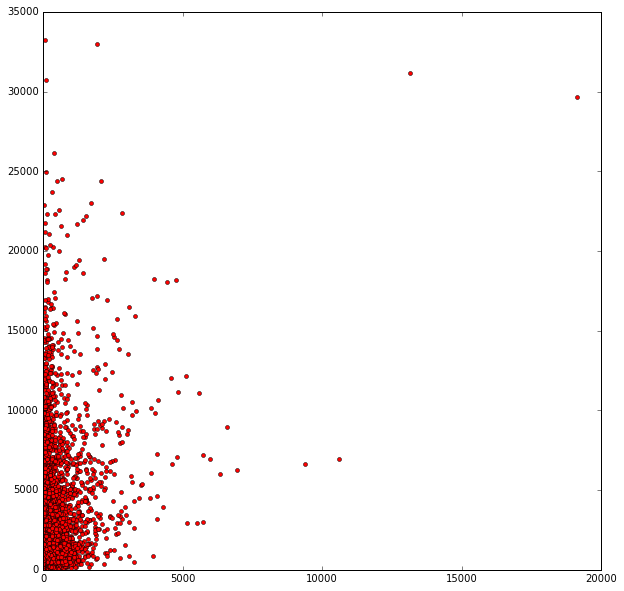

In [20]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(aggregate_df['visits_RaceBlack'], aggregate_df['visits_RaceWhite'],'ro',markersize = 4)